In [ ]:
#!pip install pmdarima

# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [ ]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [ ]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/WTI Price FOB.csv')

In [ ]:
df.head()

,Unnamed: 0,"Cushing, OK WTI Spot Price FOB, Monthly (Dollars per Barrel)"
0,1986 01,22.93
1,1986 02,15.46
2,1986 03,12.61
3,1986 04,12.84
4,1986 05,15.38


In [ ]:
df.rename(columns={'Unnamed: 0':'Year-Month','Cushing, OK WTI Spot Price FOB, Monthly (Dollars per Barrel)':'Price'}, inplace=True)
df.head()

,Year-Month,Price
0,1986 01,22.93
1,1986 02,15.46
2,1986 03,12.61
3,1986 04,12.84
4,1986 05,15.38


lets see the original dataset then we will split into train and test

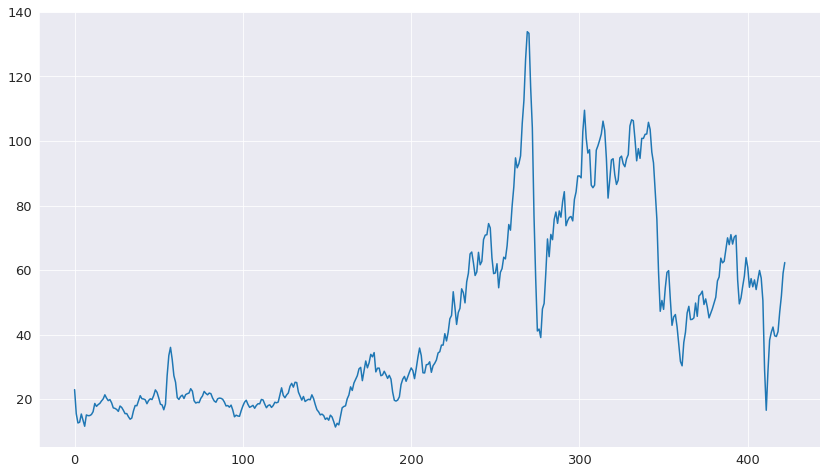

In [ ]:
plt.plot(df['Price'])

----------------------------------------------------------------------------
- We can see mix trend in the dataset but its increasing for sure
- Variance is also significant
- Seasonality is not so visible but lets decide it on the basis of ACF and PACF plots
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [ ]:
df.shape

(423, 2)

In [ ]:
df=df['Price']

In [ ]:
n=int(df.shape[0]*0.7) #test size=30% data
train=df.iloc[:n]
test=df.iloc[n:]


In [ ]:
train.shape

(296,)

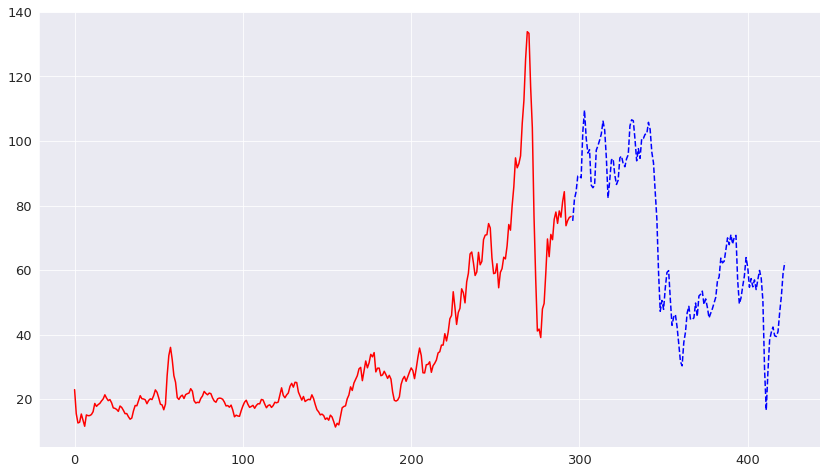

In [ ]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df)

ADF Statistic: -2.505117
p-value: 0.114234
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570
Fail to reject the null hypothesis (H0), the data is non-stationary


In [ ]:
dicky_fuller_test(train)

ADF Statistic: -0.317950
p-value: 0.922923
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance with time 

In [ ]:
# lets decompose our Time series into its components

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=12)

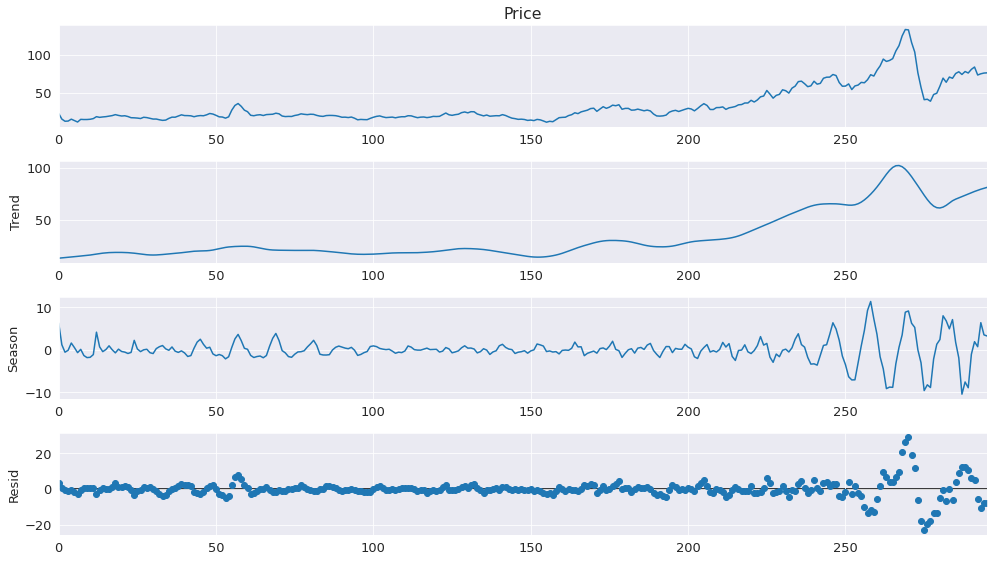

In [ ]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- No clear pattern can be seen in Seasonality so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [ ]:
df_diff1 = difference(train, interval=1)

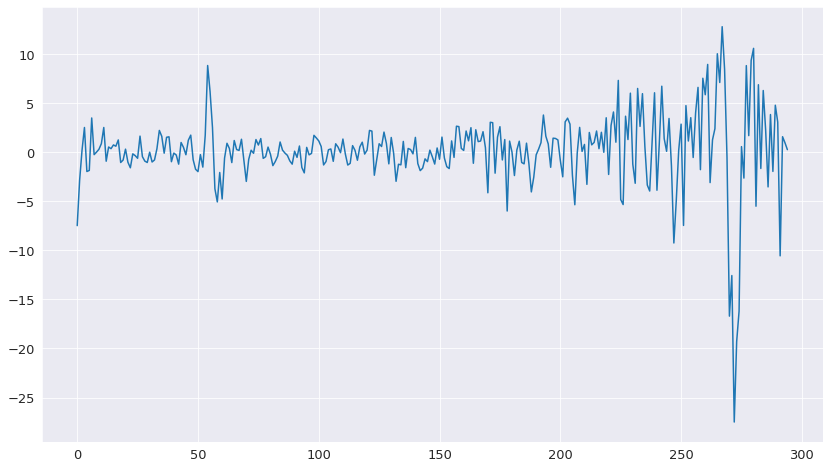

In [ ]:
plt.plot(df_diff1)

In [ ]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -7.256390
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

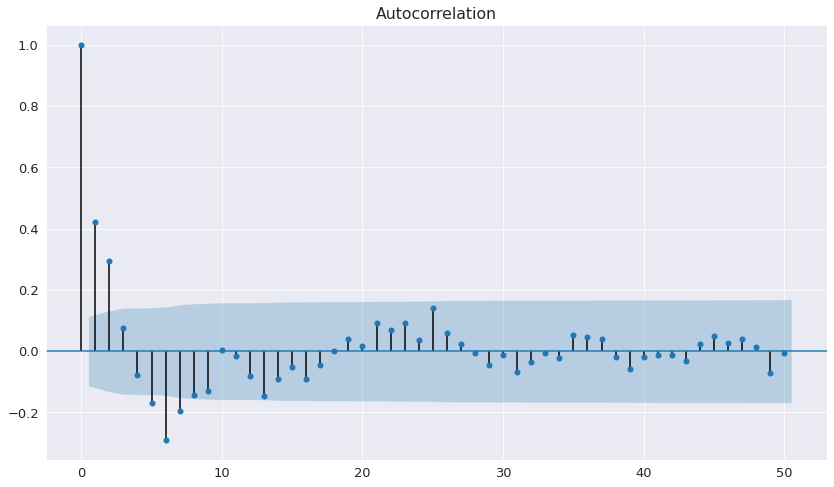

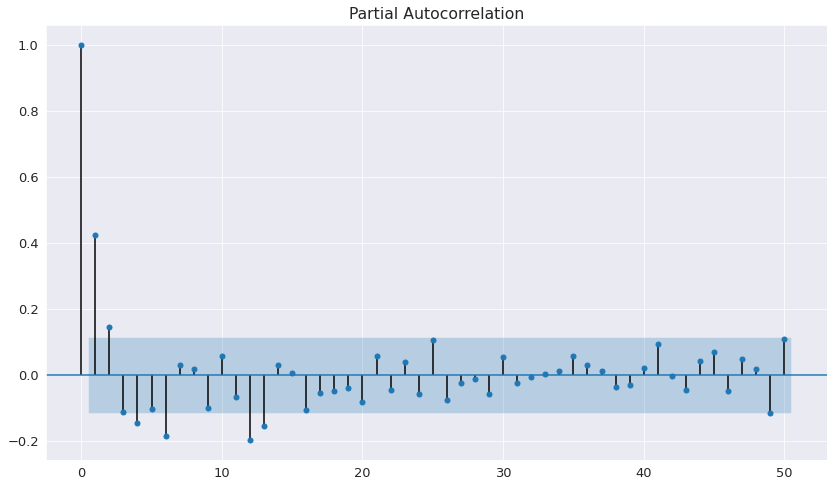

In [ ]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff1,lags=50)
fig2 = sm.graphics.tsa.plot_pacf(df_diff1,lags=50)

**Observations**
- From PACF plot we can say that p=2 as after lag 2 most for the lags are not significant
- From ACF plot q=2 as after lag 2 other lags are not that significant 
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality present in the series


In [ ]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(2,1,2)) 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  296
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -778.297
Date:                Sun, 20 Nov 2022   AIC                           1566.595
Time:                        17:15:46   BIC                           1585.030
Sample:                             0   HQIC                          1573.977
                                - 296                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4215      0.069     20.602      0.000       1.286       1.557
ar.L2         -0.7441      0.051    -14.631      0.000      -0.844      -0.644
ma.L1         -1.0883      0.075    -14.436      0.0

In [ ]:
pred_no=test.shape[0]
pred_no

127

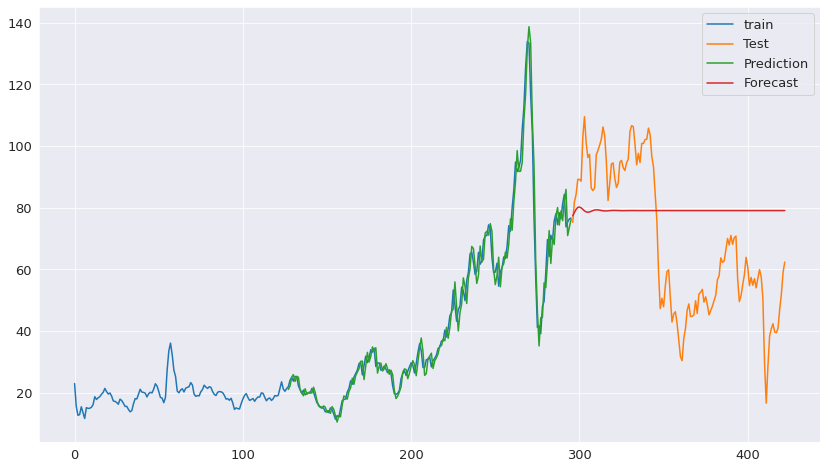

In [ ]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just an straight line trend because seasonality wasn’t taken into consideration.

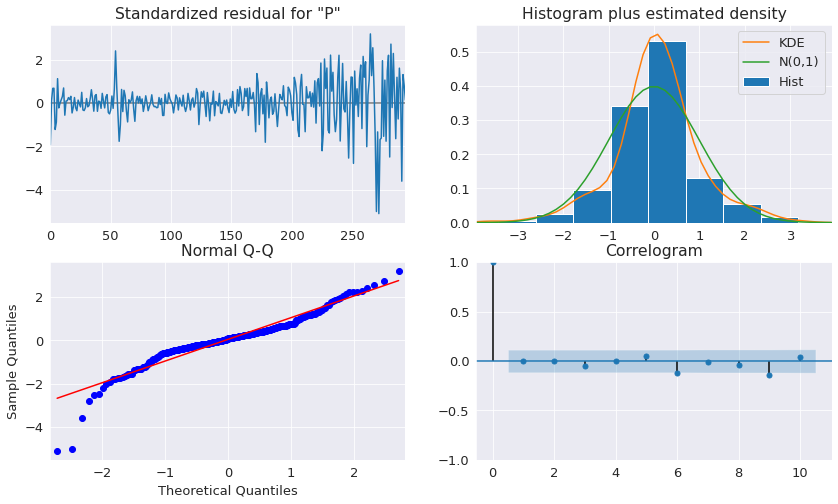

In [ ]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
test.shape

(127,)

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

25.704182920878473

In [ ]:
tsforecast.describe()

count    127.000000
mean      79.036364
std        0.247075
min       77.330571
25%       79.033684
50%       79.033733
75%       79.033840
max       80.189786
Name: predicted_mean, dtype: float64

# **Auto-Arima**

In [ ]:
from pmdarima import auto_arima

In [ ]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=20,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1641.736, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1585.231, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1603.607, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1640.383, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1581.085, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1579.207, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1574.571, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1573.862, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1565.021, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1563.315, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1561.486, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1581.736, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1563.352, Time=0.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1568.246, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

In [ ]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  296
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -774.743
Date:                Sun, 20 Nov 2022   AIC                           1561.486
Time:                        17:15:53   BIC                           1583.608
Sample:                             0   HQIC                          1570.344
                                - 296                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0284      0.021      1.356      0.175      -0.013       0.070
ar.L1          1.2254      0.052     23.653      0.000       1.124       1.327
ar.L2         -0.1149      0.072     -1.588      0.1

## Forecasting using Auto ARIMA

In [ ]:
forecast =pd.DataFrame(arima_model.predict(n_periods=pred_no),columns=['forecast'],index=test.index)
forecast

,forecast
296,77.123224
297,77.511466
298,77.884321
299,78.191993
300,78.455877
...,...
418,101.585596
419,101.783288
420,101.980980
421,102.178672


In [ ]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

,forecast,Price
296,77.123224,75.24
297,77.511466,81.89
298,77.884321,84.25
299,78.191993,89.15
300,78.455877,89.17
...,...,...
418,101.585596,40.94
419,101.783288,47.02
420,101.980980,52.00
421,102.178672,59.04


In [ ]:
forecast_df.describe()

,forecast,Price
count,127.000000,127.000000
mean,89.926921,68.599134
std,7.268645,23.590639
min,77.123224,16.550000
25%,83.695207,49.425000
50%,89.921752,60.830000
75%,96.149059,93.535000
max,102.376364,109.530000


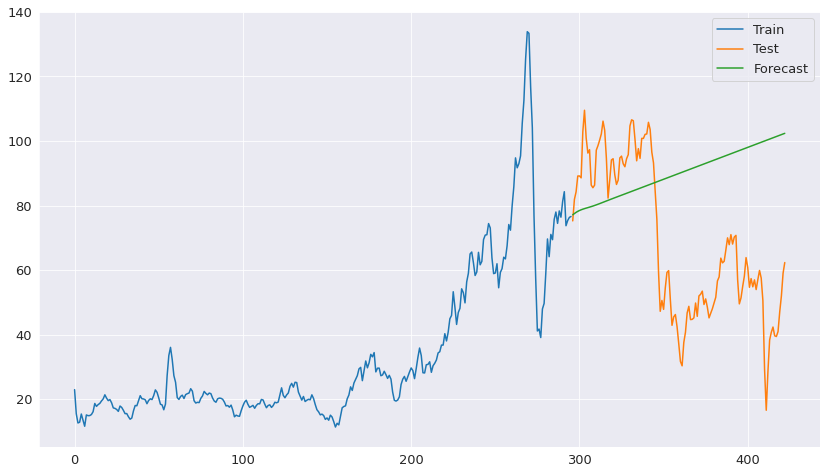

In [ ]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

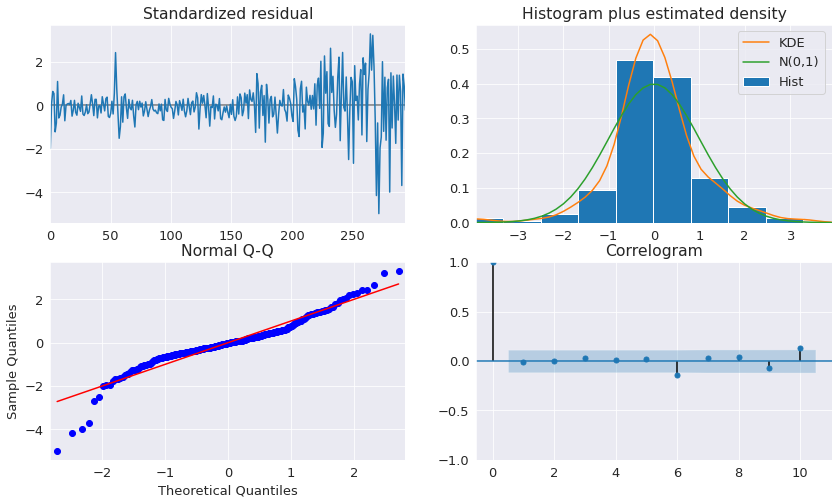

In [ ]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

Since our ARIMA model parameters p,d,q=(1,1,0) are same as that AUTO_ARIMA parameters we have got the exact same results 

In [ ]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse value: 36.257726209191624


# **Holt-Winter**

In [ ]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [ ]:
model = Holt(train)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  if self.nobs < 10 + 2 * (self.seasonal_periods // 2):


{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.5388600609027503,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 27.552794652252672,
 'initial_trend': -4.6227649789469965,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                  Price   No. Observations:                  296
Model:                           Holt   SSE                           4254.785
Optimized:                       True   AIC                            796.970
Trend:                       Additive   BIC                            811.732
Seasonal:                        None   AICC                           797.261
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:15:55
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.5388601                

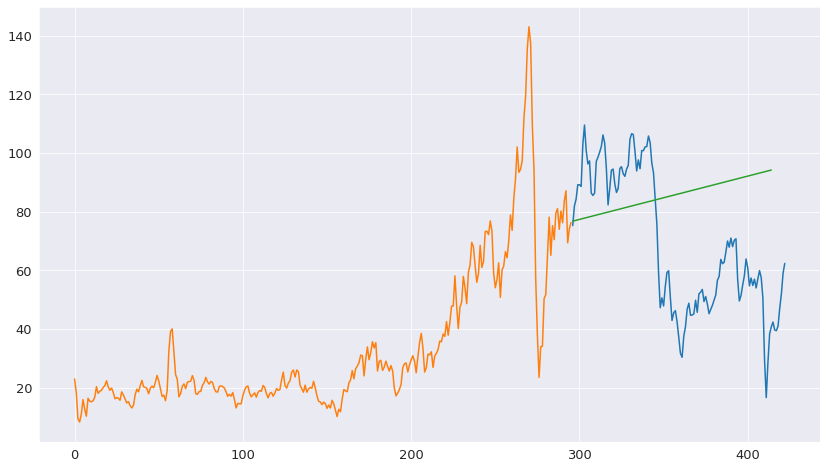

In [ ]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(119))

In [ ]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

32.82112375724959

- As rmse value of holt winters model is 32.82 which is greater than rmse value of manual ARIMA(25.7) Model, therefore we can say that for this scenario ARIMA model fits better 

In [ ]:
# lets also check manually 

In [ ]:
rolling = df.rolling(10) # moving average with window 10
type(rolling)

pandas.core.window.rolling.Rolling

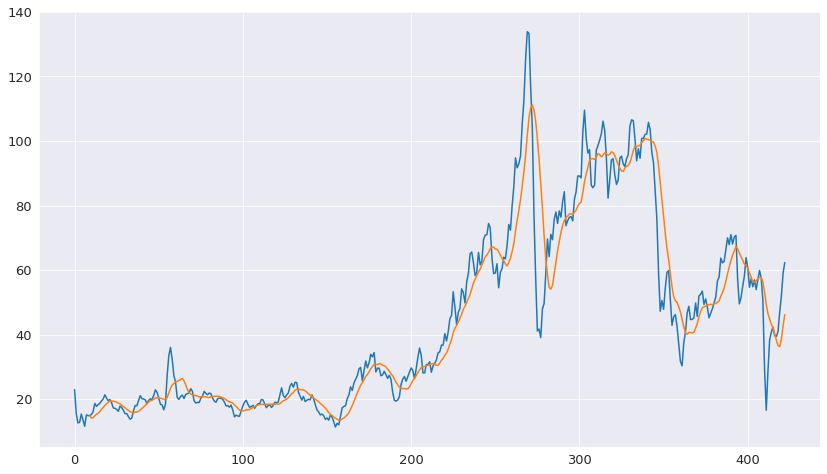

In [ ]:
mavg = rolling.mean()
plt.plot(df)
plt.plot(mavg)

In [ ]:
# Exponentially Weighted Moving Average or Exponential smoothing

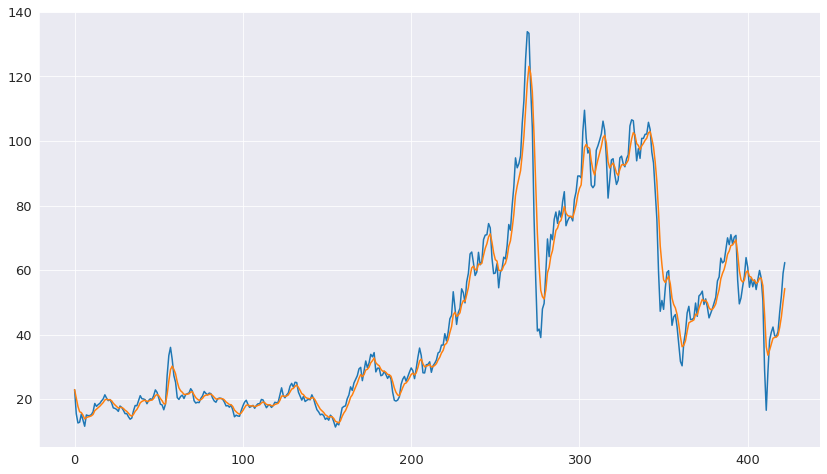

In [ ]:
# Try out the following with various values of 'alpha' and evaluate the results
ewma = df.ewm(alpha=0.34, adjust=False).mean() # as we increase alpha value our smoothing curve follows original curve # at 0.9 value it almost matches the original curve
                                              # as we decrease alpha value more smooth curve we get and less it follows original curve
plt.plot(df)
plt.plot(ewma)

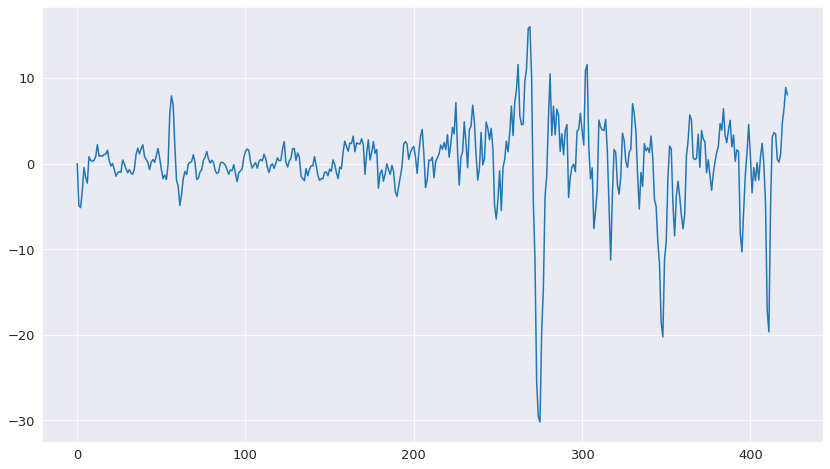

In [ ]:
plt.plot(df-ewma) # differencing transformation resulting to de-trended series

Lets apply Holt-Winter manually step by step

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
ses = SimpleExpSmoothing(train) # moving average

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  if self.nobs < 10 + 2 * (self.seasonal_periods // 2):


In [ ]:
result = ses.fit(smoothing_level=0.1, optimized=False)

In [ ]:
print(result.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Price   No. Observations:                  296
Model:             SimpleExpSmoothing   SSE                          28781.949
Optimized:                      False   AIC                           1358.835
Trend:                           None   BIC                           1366.215
Seasonal:                        None   AICC                          1358.972
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:15:57
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
initial_level              22.930000                

In [ ]:
mypred = result.predict(start=1, end=400)

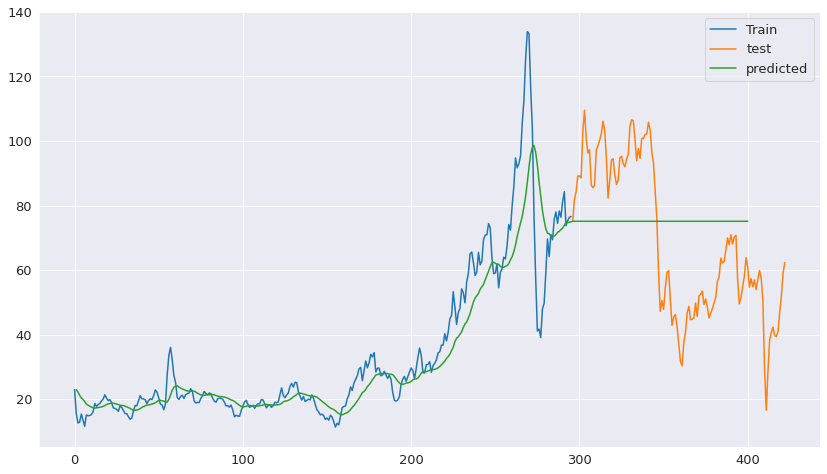

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(mypred, label='predicted')
plt.legend()

In [ ]:
result.params

{'smoothing_level': 0.1,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 22.93,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

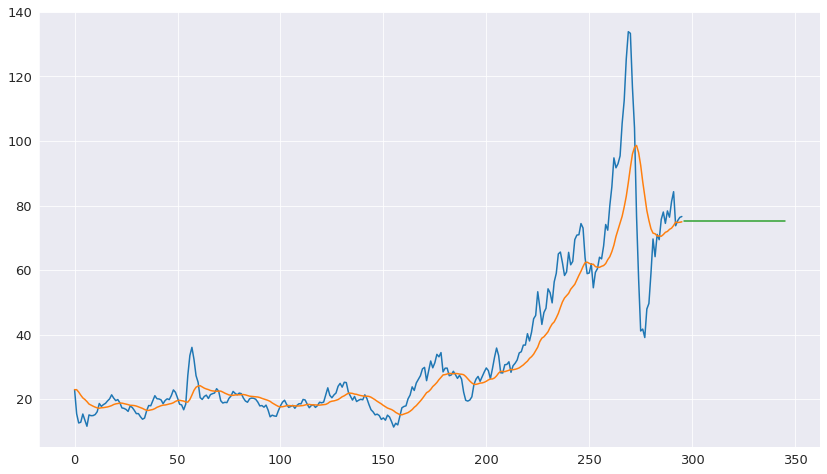

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(50))

exp smoothing


In [ ]:
# Holt's linear trend values

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
model = Holt(train, exponential=False)
result = model.fit()
result.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.5388600609027503,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 27.552794652252672,
 'initial_trend': -4.6227649789469965,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                  Price   No. Observations:                  296
Model:                           Holt   SSE                           4254.785
Optimized:                       True   AIC                            796.970
Trend:                       Additive   BIC                            811.732
Seasonal:                        None   AICC                           797.261
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         17:15:58
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.5388601                

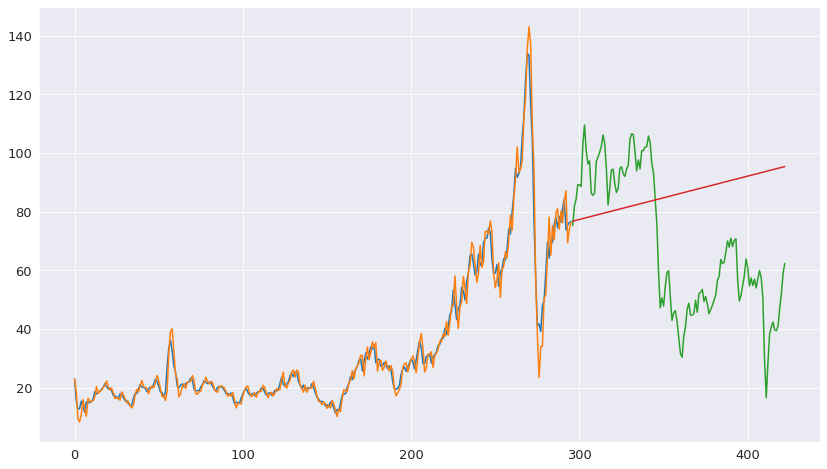

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(test)
plt.plot(result.forecast(pred_no))

We can say that its very challenging to predict crude oil prices. The fluctuations in the prices of crude oil are random and are highly dependent on demand and suppy scenerio, which is why we are getting incorrect prediction values  

If we keep the test size to be 20% we get better result in Holt's model as compared to ARIMA as holt model predicts the values as increasing trend and not a flat line 